### ZScoring by Block
- Develop z-scoring methods per block, both for values and for firing rates
- See if after z-scoring, correlations with units still hold
- Try to motivate running GLMs on z-scored firing rates + values

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
from scipy import stats
import warnings
from scipy.ndimage import gaussian_filter1d

warnings.filterwarnings('ignore')



In [2]:
session = 20181010
num_bins = 10
behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
beh = pd.read_csv(behavior_path)

# filter trials 
valid_beh = behavioral_utils.get_valid_trials(beh)
feature_selections = behavioral_utils.get_selection_features(valid_beh)
valid_beh = pd.merge(valid_beh, feature_selections, on="TrialNumber", how="inner")
beh = behavioral_utils.get_feature_values_per_session(session, valid_beh)
beh = behavioral_utils.get_relative_block_position(beh, num_bins)
beh = behavioral_utils.get_max_feature_value(beh, num_bins)
# fr_path = f"/data/patrick_res/firing_rates/{session}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{NUM_BINS_SMOOTH}_smooth.pickle"

In [3]:
res = behavioral_utils.zscore_feature_vals_by_block(beh)

### Take a look at what z-scored max feature values look like, compare to original max feat values

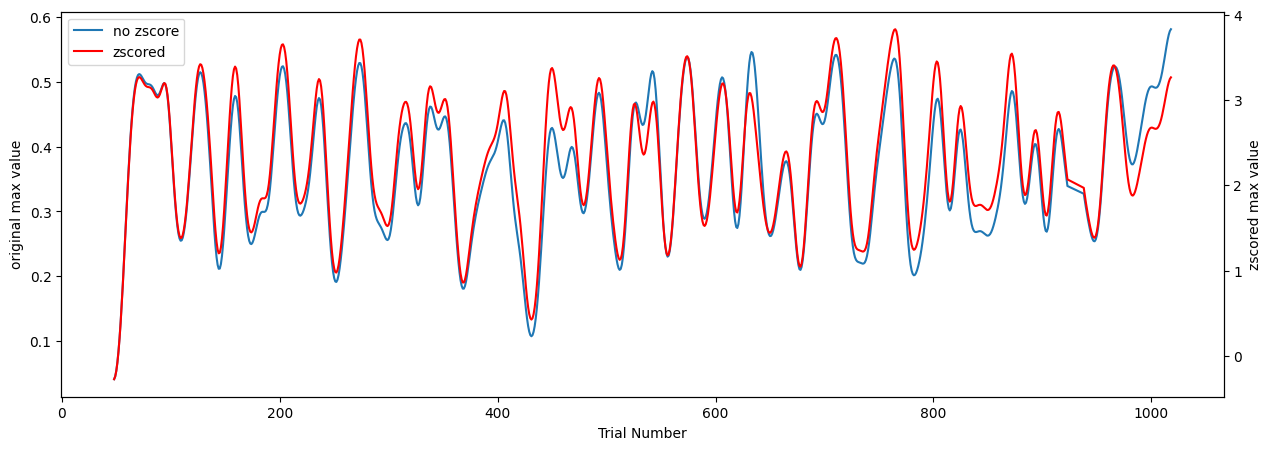

In [11]:
fig, ax = plt.subplots(figsize=(15, 5))
original = gaussian_filter1d(res.MaxValue.values, 5)
ln1 = ax.plot(res.TrialNumber, original, label="no zscore")
ax.set_xlabel("Trial Number")
ax.set_ylabel("original max value")
ax_z = ax.twinx()
zscored = gaussian_filter1d(res.MaxValueBlockZ.values, 5)
ln2 = ax_z.plot(res.TrialNumber, zscored, color='r', label="zscored")
ax_z.set_ylabel("zscored max value")

lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

### Want to see if top N units from GLM are still correlated with max value after zscoring by block

In [26]:
OUTPUT_DIR = "/data/patrick_res/glm_2"
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)

In [27]:
model = "Linear"

def get_agg_glm_res(session):
    # res_name = f"{session}_glm_{fb_type}_residual_fr_{MODE}_{INTERVAL_SIZE}_{MODEL}_values.pickle"
    res_name = f"{session}_glm_{EVENT}_{MODE}_{INTERVAL_SIZE}_{model}_values_agg.pickle"
    res = pd.read_pickle(os.path.join(OUTPUT_DIR, res_name))
    res["session"] = session
    res["PseudoUnitID"] = int(session) * 100 + res.UnitID
    return res
glm_res = pd.concat(sessions.apply(lambda x: get_agg_glm_res(x.session_name), axis=1).values)

In [28]:
positions = spike_utils.get_unit_positions(sessions)
merged = pd.merge(glm_res, positions, on=["PseudoUnitID", "session", "UnitID"])

In [29]:
SMOOTH = 1
num_bins = 10

def visualize_correlations(row):
    session = row.session

    behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
    beh = pd.read_csv(behavior_path)

    # filter trials 
    valid_beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(valid_beh)
    valid_beh = pd.merge(valid_beh, feature_selections, on="TrialNumber", how="inner")
    beh = behavioral_utils.get_feature_values_per_session(session, valid_beh)
    beh = behavioral_utils.get_relative_block_position(beh, num_bins)
    beh = behavioral_utils.get_max_feature_value(beh, num_bins)
    beh = behavioral_utils.zscore_feature_vals_by_block(beh, num_bins)

    fr_path = f"/data/patrick_res/firing_rates/{session}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{SMOOTH}_smooth.pickle"

    frs = pd.read_pickle(fr_path)
    frs = frs[frs.UnitID == row.UnitID]
    agg = frs.groupby(["UnitID", "TrialNumber"]).mean().reset_index()
    merged = pd.merge(agg, beh, on="TrialNumber")
    merged = spike_utils.zscore_frs(merged, group_cols=["UnitID", "BlockNumber"], mode="FiringRate")
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    ax = axs[0, 0]
    visualization_utils.plot_mean_sterrs_by_bin(merged, "FiringRate", "MaxValueBin", ax, row.PseudoUnitID, num_bins)
    # visualization_utils.plot_mean_sterrs_by_block_pos(beh, "MaxValue", ax, row.PseudoUnitID, num_block_bins)
    ax.set_xlabel("Max Value Bin")
    ax.set_ylabel("Mean firing in inter-trial")
    ax.set_title(f"{row.structure_level2}: {row.PseudoUnitID}")

    ax = axs[0, 1]
    # merged_filt = merged[merged.MaxValue > 0.3]
    visualization_utils.plot_mean_sterrs_by_bin(merged, "ZFiringRate", "MaxValueBlockZBin", ax, row.PseudoUnitID, num_bins)
    # visualization_utils.plot_mean_sterrs_by_block_pos(beh, "MaxValue", ax, row.PseudoUnitID, num_block_bins)
    ax.set_ylabel("ZScored Mean firing in inter-trial")
    ax.set_xlabel("ZScored Max Value Bin")

    ax = axs[1, 0]
    slope, intercept, r_value, p_value, std_err = stats.linregress(merged["MaxValue"], merged["FiringRate"])
    ax.scatter(merged["MaxValue"], merged["FiringRate"], alpha=0.3, color="black")
    ax.plot(merged["MaxValue"], merged["MaxValue"] * slope + intercept)
    ax.set_title(f"Cor w Max Value: r: {r_value:.3f}, p: {p_value:.3E}")
    ax.set_xlabel("Max Value Bin")
    ax.set_ylabel("Mean firing in inter-trial")

    ax = axs[1, 1]
    slope, intercept, r_value, p_value, std_err = stats.linregress(merged["MaxValueBlockZ"], merged["ZFiringRate"])
    ax.scatter(merged["MaxValueBlockZ"], merged["ZFiringRate"], alpha=0.3, color="black")
    ax.plot(merged["MaxValueBlockZ"], merged["MaxValueBlockZ"] * slope + intercept)
    ax.set_title(f"Cor w Max Value: r: {r_value:.3f}, p: {p_value:.3E}")
    ax.set_xlabel("ZScored Max Value")
    ax.set_ylabel("ZScored Mean firing in inter-trial")
    
    fig.tight_layout()

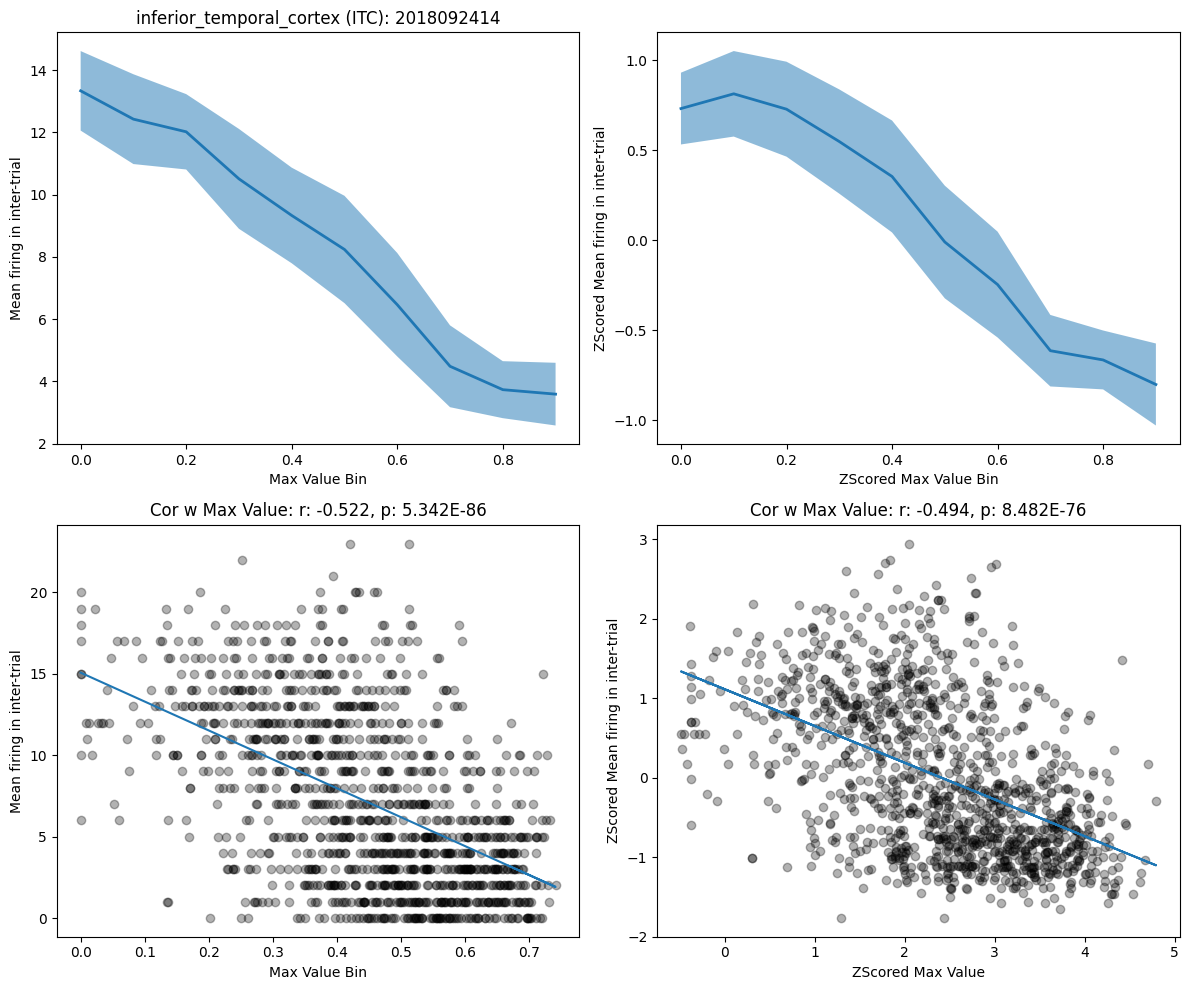

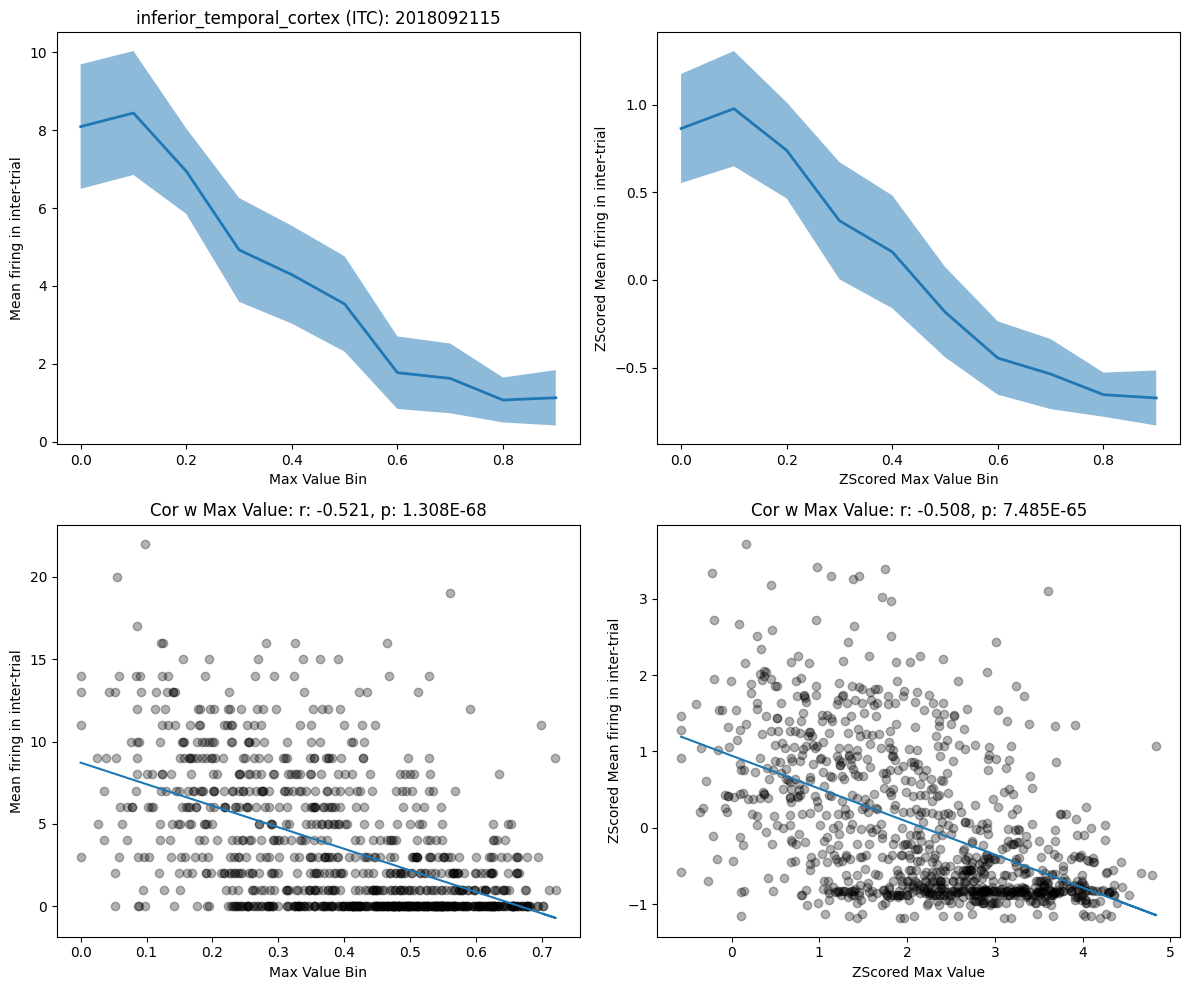

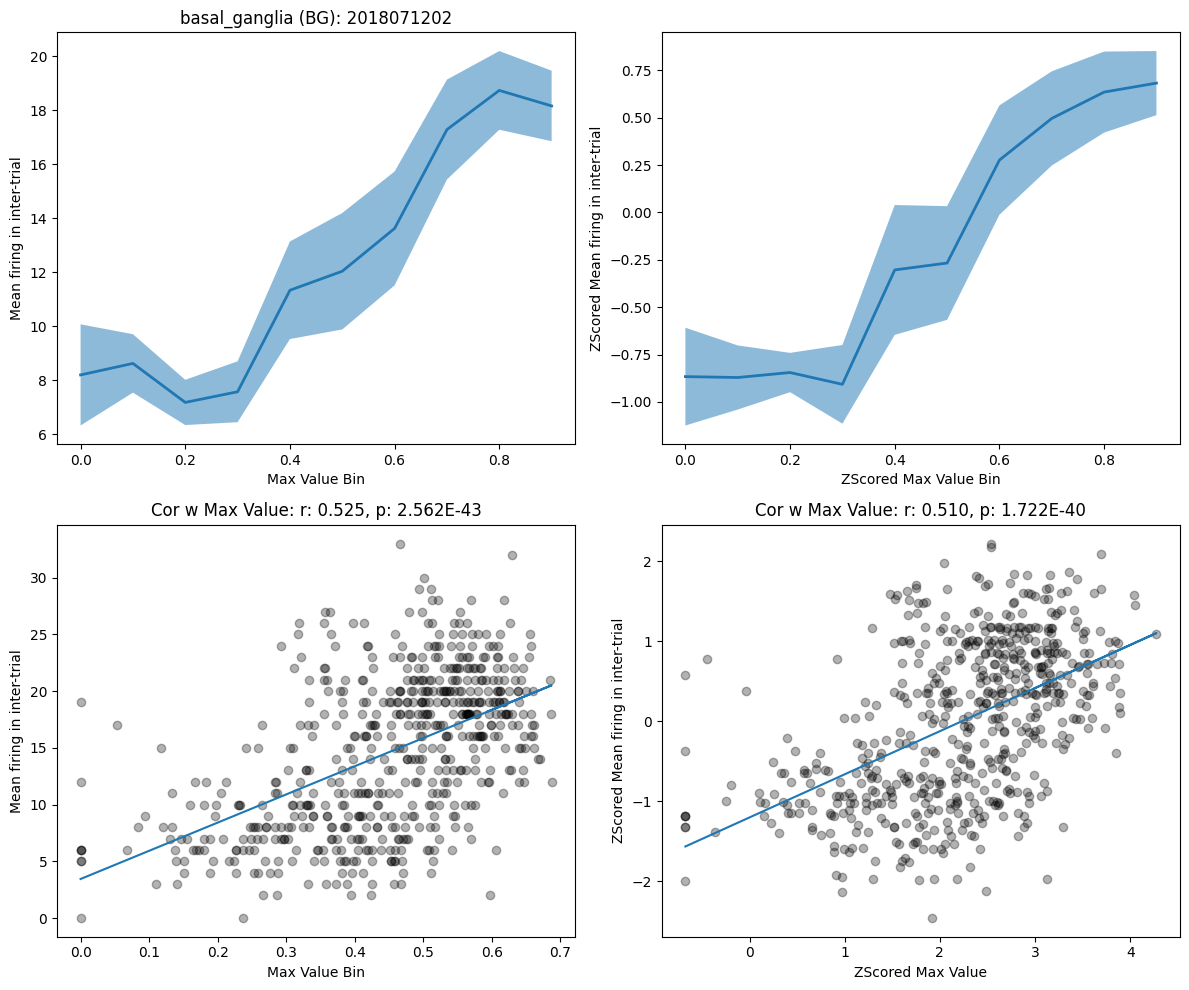

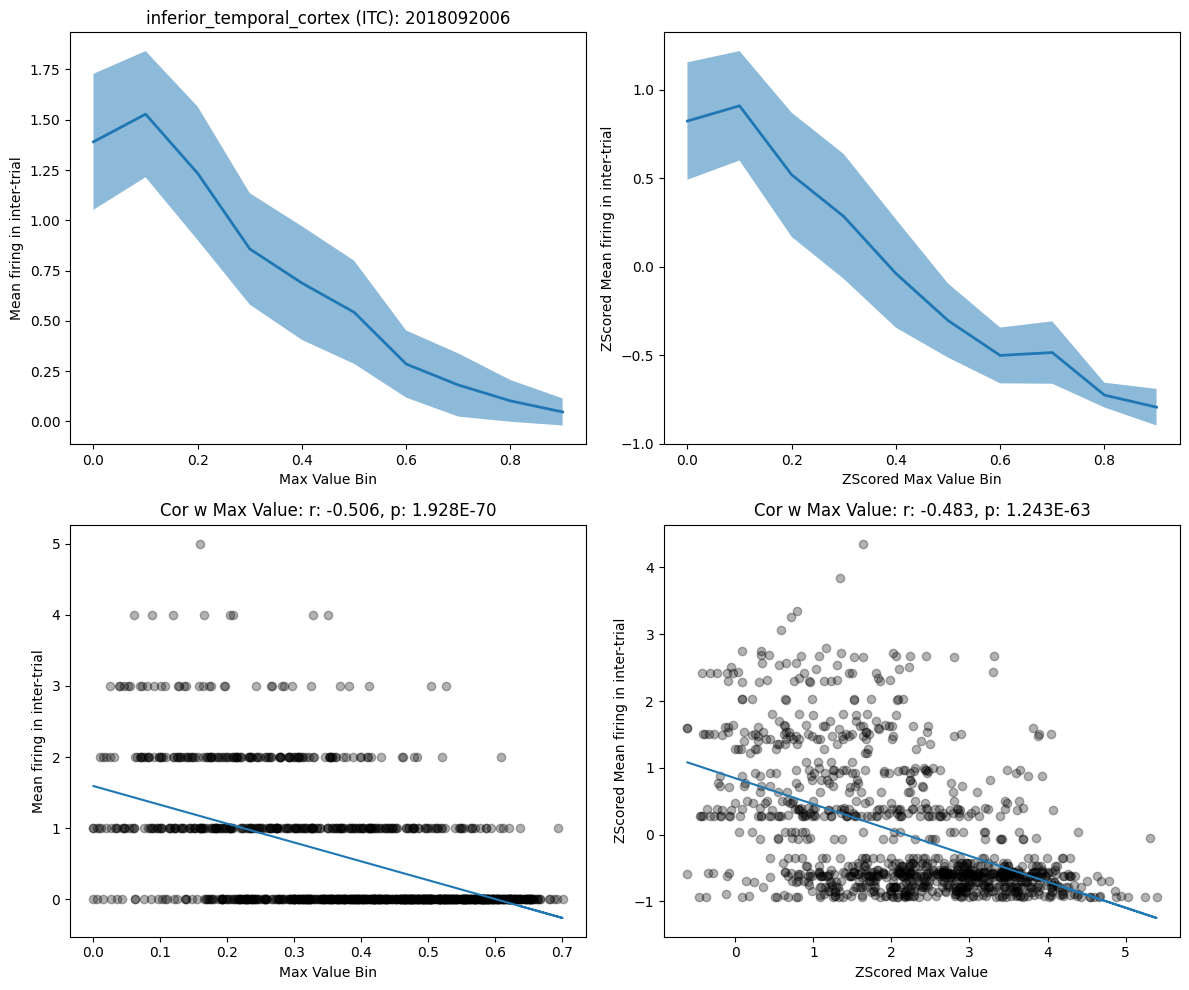

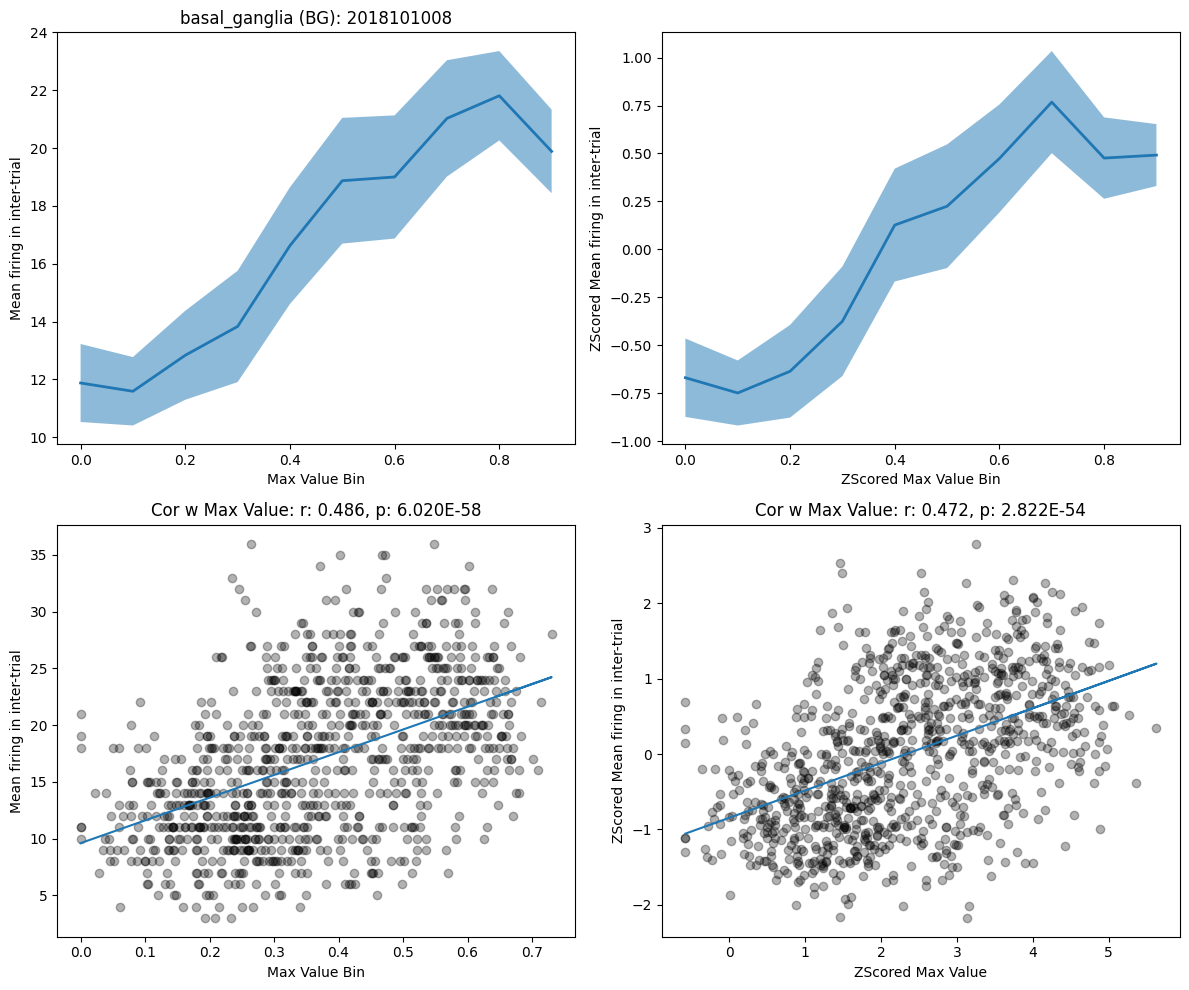

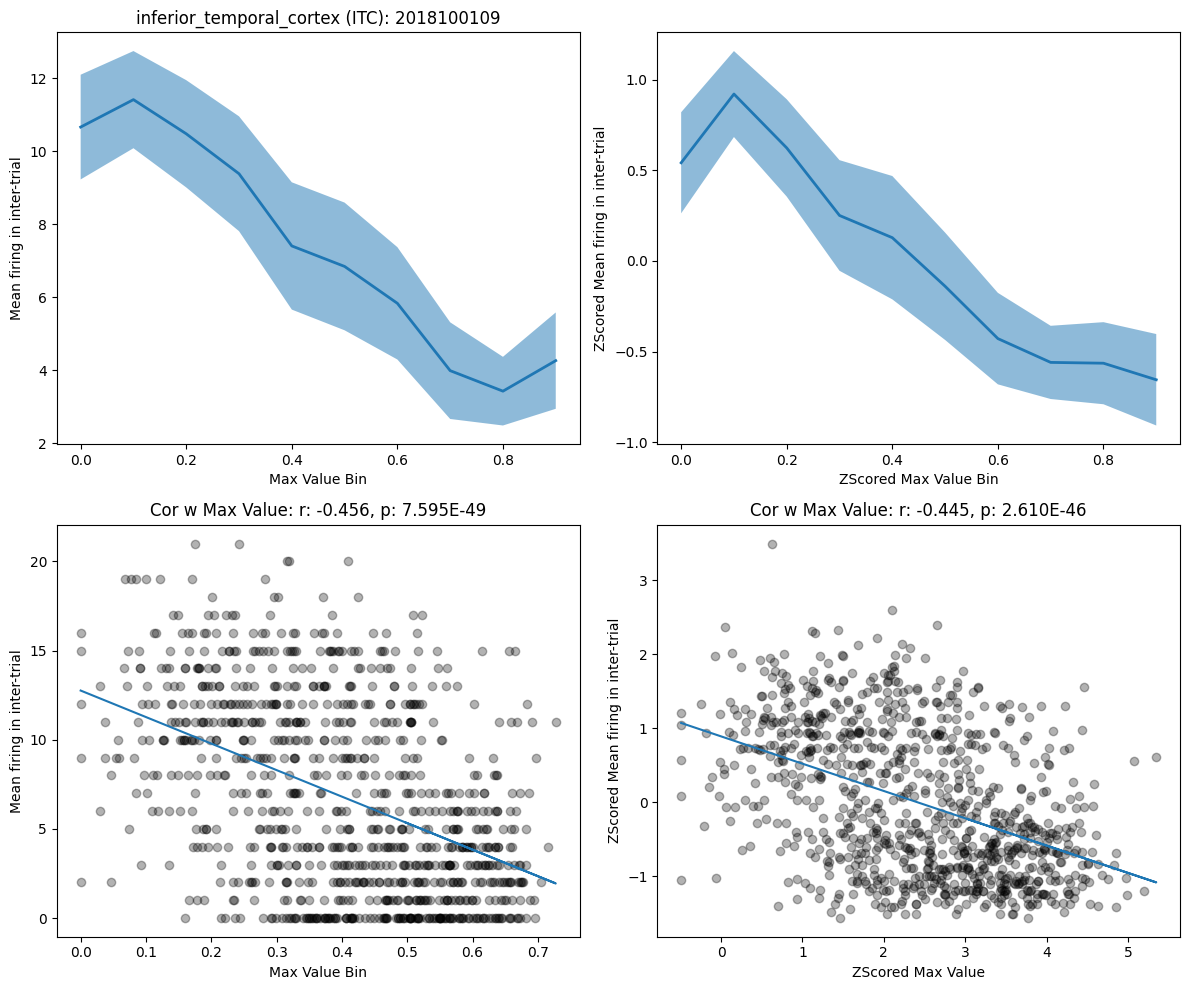

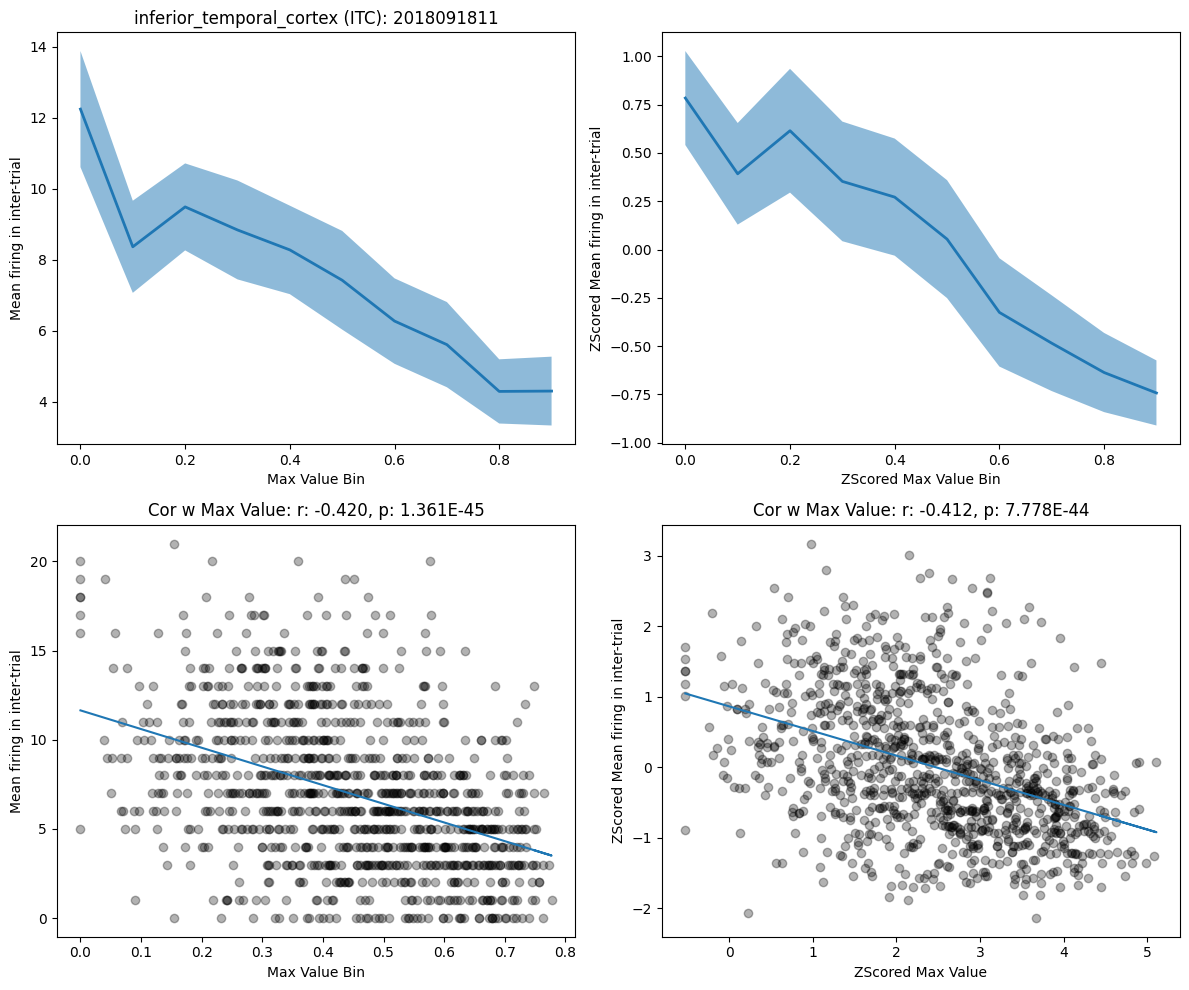

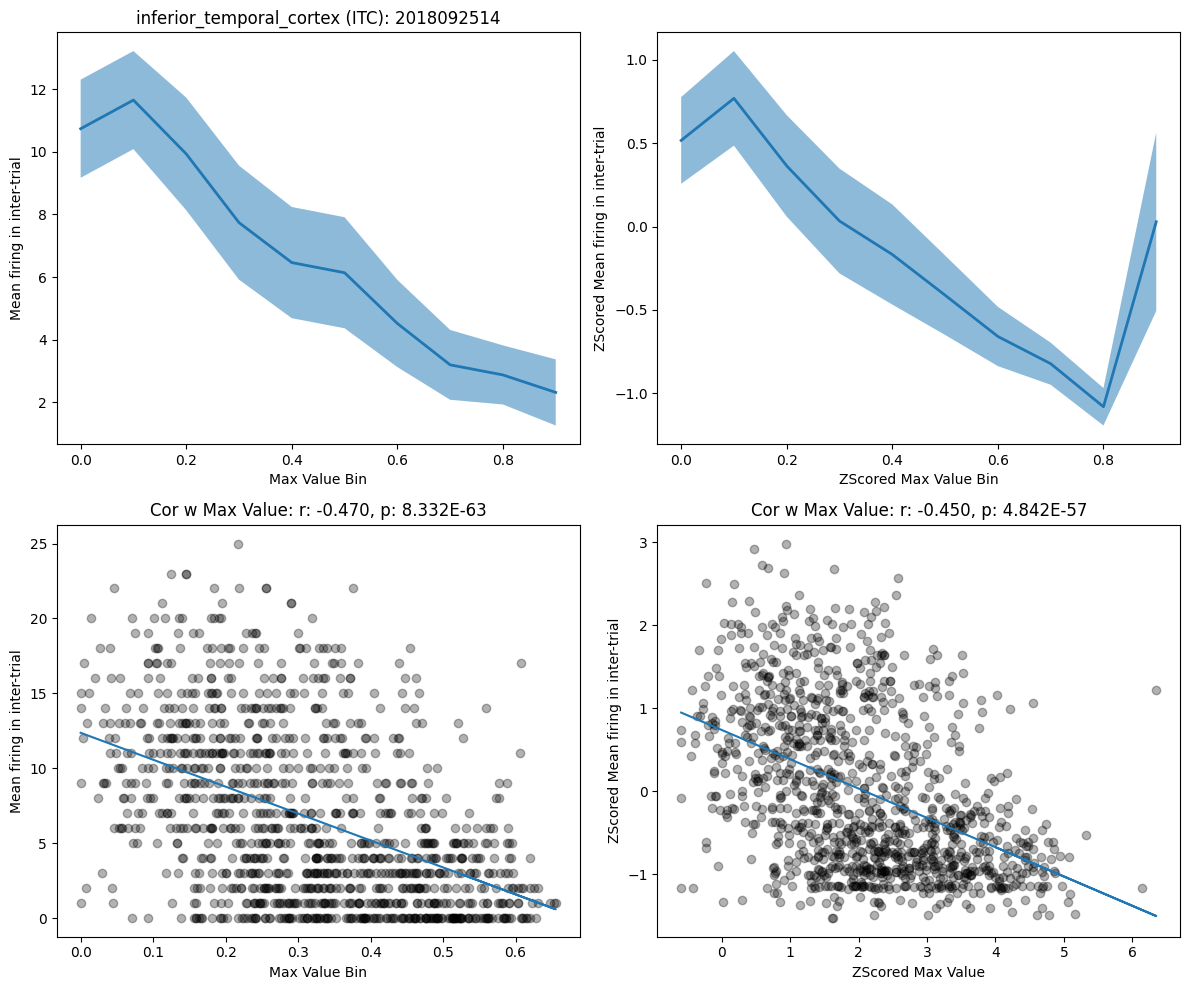

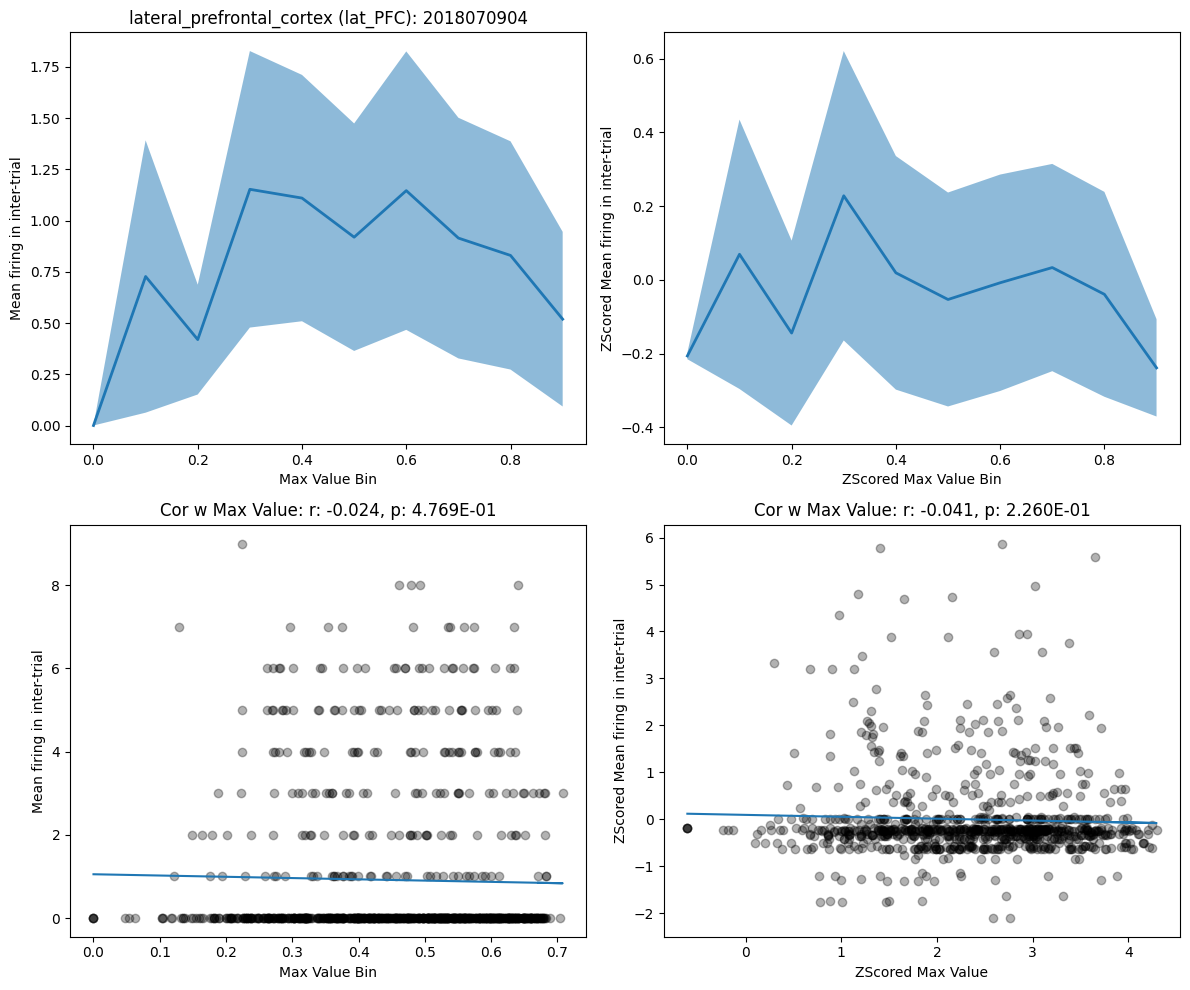

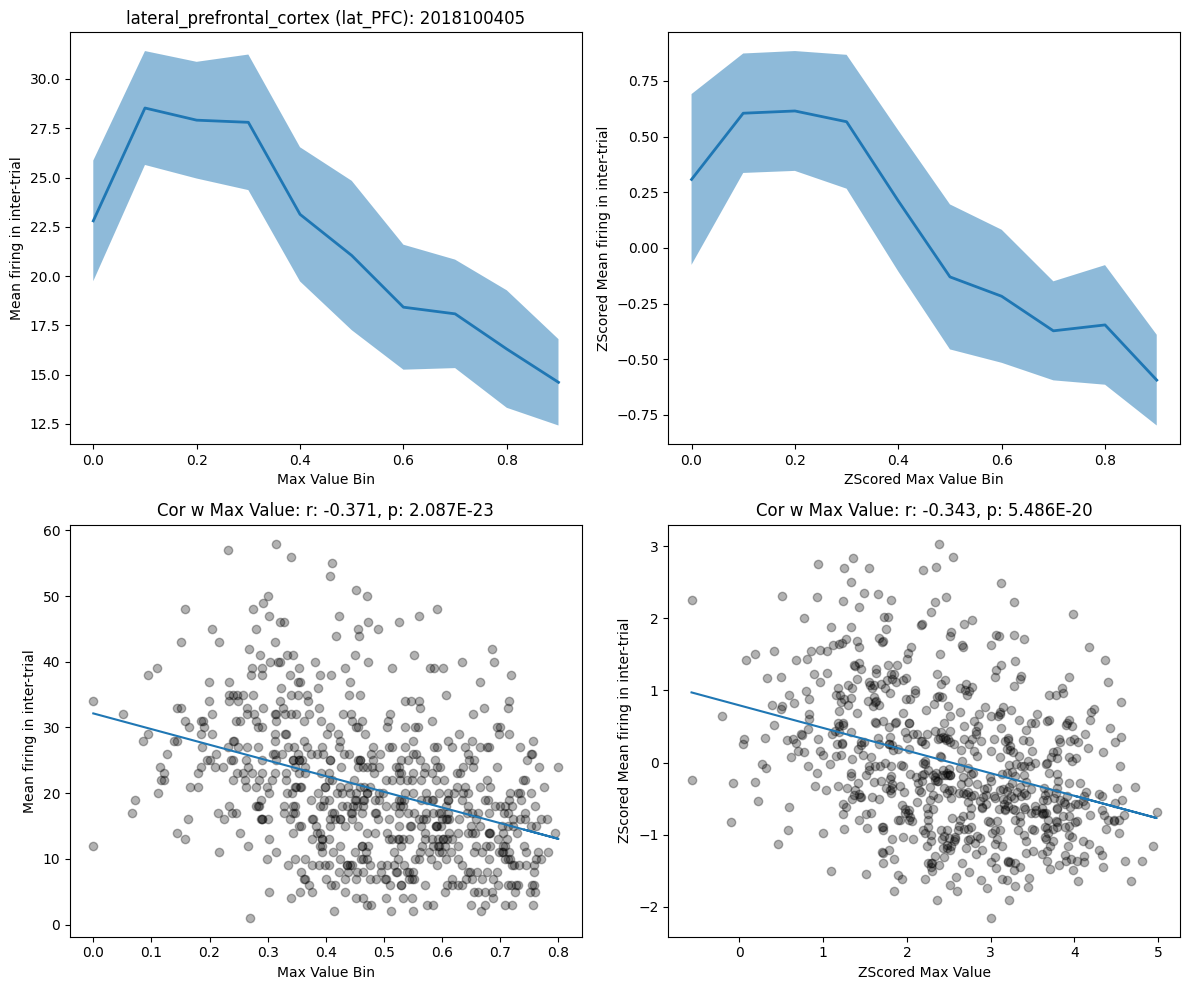

In [30]:
top_10 = merged.sort_values(by="score", ascending=False)[:10]
for i, row in top_10.iterrows():
    visualize_correlations(row)

### Scrap

In [17]:
id = 2018070904
row = merged[merged.PseudoUnitID == id].iloc[0]
session = row.session

behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
beh = pd.read_csv(behavior_path)

# filter trials 
valid_beh = behavioral_utils.get_valid_trials(beh)
feature_selections = behavioral_utils.get_selection_features(valid_beh)
valid_beh = pd.merge(valid_beh, feature_selections, on="TrialNumber", how="inner")
beh = behavioral_utils.get_feature_values_per_session(session, valid_beh)
beh = behavioral_utils.get_relative_block_position(beh, num_bins)
beh = behavioral_utils.get_max_feature_value(beh, num_bins)
beh = behavioral_utils.zscore_feature_vals_by_block(beh, num_bins)

fr_path = f"/data/patrick_res/firing_rates/{session}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{SMOOTH}_smooth.pickle"

frs = pd.read_pickle(fr_path)
frs = frs[frs.UnitID == row.UnitID]
agg = frs.groupby(["UnitID", "TrialNumber"]).mean().reset_index()
merged = pd.merge(agg, beh, on="TrialNumber")
merged = spike_utils.zscore_frs(merged, group_cols=["UnitID", "BlockNumber"], mode="FiringRate")

In [19]:
slope, intercept, r_value, p_value, std_err = stats.linregress(merged["MaxValueBlockZ"], merged["ZFiringRate"])

In [9]:
beh[:10].TrialNumber

0    48
1    49
2    50
3    51
4    52
5    53
6    54
7    55
8    56
9    57
Name: TrialNumber, dtype: int64

In [10]:
max_feats = beh.TrialNumber.values
rng = np.random.default_rng()
rng.shuffle(max_feats)
beh["TrialNumber"] = max_feats

In [12]:
beh[:10].TrialNumber

0    906
1    591
2    334
3    898
4    111
5     54
6    545
7    671
8     49
9    750
Name: TrialNumber, dtype: int64

In [25]:
merged[merged["ZFiringRate"].isna()]

,UnitID,TrialNumber,TimeBins,SpikeCounts,FiringRate,index,BlockNumber,TrialAfterRuleChange,TaskInterrupt,ConditionNumber,...,GREENValueBlockZ,MAGENTAValueBlockZ,YELLOWValueBlockZ,ESCHERValueBlockZ,POLKADOTValueBlockZ,RIPPLEValueBlockZ,SWIRLValueBlockZ,MaxValueBlockZ,MaxValueBlockZBin,ZFiringRate
37,4,86,0.475,0.0,0.0,37,3,0,NaN,1208,...,0.307138,0.528078,0.256395,-0.345276,0.337530,0.289751,0.755316,3.750351,8,NaN
38,4,87,0.475,0.0,0.0,38,3,1,NaN,1508,...,-0.507072,0.373167,0.135659,-1.159487,0.206589,0.164819,0.571820,2.936141,7,NaN
39,4,88,0.475,0.0,0.0,39,3,2,NaN,1595,...,-0.507072,0.373166,1.040084,-1.159486,0.206588,1.069244,0.571818,2.936136,7,NaN
40,4,89,0.475,0.0,0.0,40,3,3,NaN,1246,...,0.343269,0.373164,1.040082,-1.159485,1.056929,1.069242,0.571817,2.936132,7,NaN
41,4,90,0.475,0.0,0.0,41,3,4,NaN,1380,...,-0.490379,0.237740,0.820765,-1.102114,0.835492,0.846257,-0.261832,2.102483,5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656,4,705,0.475,0.0,0.0,656,22,24,NaN,894,...,0.232294,0.099981,1.017080,-0.328346,-0.272430,0.954266,1.179417,3.392978,8,NaN
657,4,706,0.475,0.0,0.0,657,22,25,NaN,773,...,0.232293,0.099980,1.211979,-0.328346,-0.077530,0.954264,1.179415,3.587878,8,NaN
658,4,707,0.475,0.0,0.0,658,22,26,NaN,927,...,0.232292,0.204968,1.211977,-0.328347,-0.077531,1.059252,1.179413,3.692865,8,NaN
659,4,708,0.475,0.0,0.0,659,22,27,NaN,1063,...,0.232291,0.204967,1.081361,-0.328347,-0.077531,0.928635,1.179411,3.562249,8,NaN
